In [3]:
# ================================================================
# Import cell
# ================================================================
import os
import re
import math
import time
from time import perf_counter
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils as vutils
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from tqdm.auto import tqdm

# Set a fixed seed across PyTorch, NumPy, and Python’s random module to ensure reproducible results
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
# ------------------------------------------------------------------
# Device
# ------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


# Dataset Preprocessing

**Dataset**: Fashion-MNIST\
**Description**: Images of Zalando clothing items, each a 28×28 grayscale image labeled with one of 10 categories\
**Size**: 60,000 training images, 10,000 test images

**PyTorch docs**: https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html

Loaded stats from ./fmnist_stats.csv
Mean: [0.2860406339168548]
Std : [0.3530241549015045]


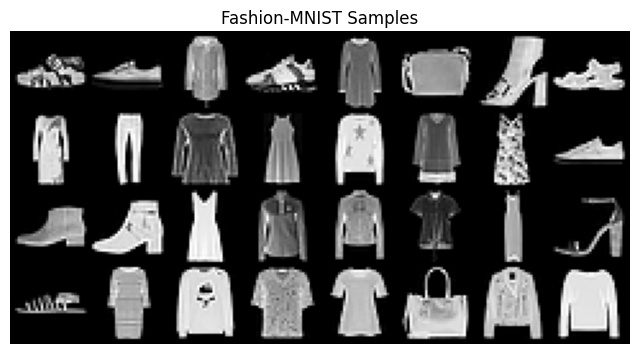

In [5]:
# ----------------------------------------------------------------------------
# 0.  Path to save/load dataset statistics (avoid recompute)
# ----------------------------------------------------------------------------
STATS_PATH = "./fmnist_stats.csv"

# ----------------------------------------------------------------------------
# 1.  Raw Fashion‑MNIST dataset
# ----------------------------------------------------------------------------
RAW_TRAIN_DS = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor() # PIL image (pixels in [0,255])  -> tensor [1, 28, 28] (pixels in [0,1])
)

def compute_mean_std(dataset, batch_size: int = 256, num_workers: int = 4):
    """
    Return per‑channel mean and std for a dataset of [0,1] images.
    """
    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers,
                        pin_memory=True)

    # Instantiate as zeros
    n_pixels = 0
    sum_    = torch.zeros(1)
    sum_sq  = torch.zeros(1)

    for imgs, _ in loader:                 # imgs: [B, 1, 28, 28]
        b, c, h, w = imgs.shape
        imgs = imgs.view(b, c, -1)         # [B, 1, H*W] - two last axes flattened
        n_pixels += b * h * w
        # Batch-wise stats -> dim=(0,2) reduces over batch and flattened‑pixel axis
        sum_   += imgs.sum(dim=(0, 2))
        sum_sq += (imgs ** 2).sum(dim=(0, 2))

    mean = sum_ / n_pixels
    var  = sum_sq / n_pixels - mean ** 2   # Var(X)=E[X^2]−(E[X])^2
    std  = torch.sqrt(var)
    return mean, std

# ----------------------------------------------------------------------------
# 2.  Load or compute & save stats
# ----------------------------------------------------------------------------
if os.path.exists(STATS_PATH):
    df = pd.read_csv(STATS_PATH, index_col=0)
    FMNIST_MEAN = torch.tensor(df['mean'].values)
    FMNIST_STD  = torch.tensor(df['std'].values)
    print(f"Loaded stats from {STATS_PATH}")
else:
    FMNIST_MEAN, FMNIST_STD = compute_mean_std(RAW_TRAIN_DS)
    df = pd.DataFrame({
        'mean': FMNIST_MEAN.tolist(),
        'std' : FMNIST_STD.tolist()
    }, index=['Channel 0'])
    df.to_csv(STATS_PATH)
    print(f"Computed & saved stats to {STATS_PATH}")

print(f"Mean: {FMNIST_MEAN.tolist()}")
print(f"Std : {FMNIST_STD.tolist()}")

# ----------------------------------------------------------------------------
# 3.  Normalized DataLoaders
# ----------------------------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(FMNIST_MEAN, FMNIST_STD), # (x - μ) / σ
    # zero‑mean, unit‑variance -> faster convergence, stabler optimisation
])

train_loader = DataLoader(
    datasets.FashionMNIST("./data", train=True,  download=False, transform=transform),
    batch_size=128,
    shuffle=True, # Shuffle training data to create varied mini-batches and break up any ordering bias
    num_workers=4, # Number of background worker processes (OS-level subprocesses) used to load and preprocess data in parallel
    pin_memory=True # Enable pinned memory so batches stay in RAM and the GPU can fetch them faster via direct DMA
)
test_loader = DataLoader(
    datasets.FashionMNIST("./data", train=False, download=False, transform=transform),
    batch_size=128,
    shuffle=False, # Keep test data in a fixed order for consistent, reproducible evaluation
    num_workers=4,
    pin_memory=True
)

# ----------------------------------------------------------------------------
# 4.  Utility helpers: denormalize & visualize
# ----------------------------------------------------------------------------
def denormalize(tensor, mean=FMNIST_MEAN, std=FMNIST_STD):
    """
    Invert a torchvision Normalize() in‑place.
    tensor: [B,1,H,W] or [1,H,W]
    """
    # .view(-1, 1, 1) = reshapes the 1D vectors -> 3D tensor of shape [C, H=1, W=1]
    mean = mean.to(tensor.device).view(-1, 1, 1)
    std  = std.to(tensor.device).view(-1, 1, 1)
    return tensor * std + mean


def show_images(img_batch, mean=FMNIST_MEAN, std=FMNIST_STD, nrow=8, title=None):
    """
    Display a grid of normalized images after automatic denormalization.
    """
    imgs = denormalize(img_batch.clone().cpu(), mean, std).clamp(0, 1)   # Denormalize a CPU copy of the batch, clamp pixel values to [0,1]
    grid = vutils.make_grid(imgs, nrow=nrow)                             # Arrange images into a grid with nrow images per row
    np_grid = grid.permute(1, 2, 0).numpy()                              # Reorder tensor to (H, W, C) and convert to NumPy array

    plt.figure(figsize=(nrow, nrow))                                     # Create a square figure sized to the grid
    plt.axis('off')                                                      # Hide axis ticks and labels
    if title:
        plt.title(title)                                                 # Set the plot title if provided
    plt.imshow(np_grid[:, :, 0], cmap='gray')                            # Display the first channel as a grayscale image
    plt.show()                                                           # Render the figure on screen


# ----------------------------------------------------------------------------
# 5.  Quick sanity‑check
# ----------------------------------------------------------------------------
example_imgs, _ = next(iter(train_loader))
show_images(example_imgs[:32], title="Fashion‑MNIST Samples")

# Model Definition

In this section we define a common VAE toolkit (_VAEMixin) for sampling, (de)normalization and loss terms, then build three VAE variants:
- standard convolutional encoder–decoder (ConvVAE)
- β-VAE that anneals the KL weight over epochs (BetaVAE)
- flow-augmented VAE that applies a sequence of invertible planar flows to enrich the posterior (FlowVAE)

Each uses a unified forward and loss interface for easy training and comparison.

#### Additional explanations for following code:
1. @staticmethod\
@staticmethod - a method that lives on the class but doesn’t receive self (instance) or cls (class) argument — it’s just a function grouped with the class. We use it when methods don’t rely on any instance or class state, are just a pure functions bundled with the VAE.

2. Parameters of nn.ConvTranspose2d\
nn.ConvTranspose2d( \
    `in_channels`,   # number of input feature maps (depth of incoming tensor) \
    `out_channels`,  # number of output feature maps (depth of resulting tensor) \
    `kernel_size`,   # spatial size of the transposed convolution filter (height and width) \
    `stride`,        # step size between filter applications; also determines upsampling factor \
    `padding`        # number of zero-pixels added to each side of the input before convolution \
)

In [6]:
# ------------------------------------------------------------
# 0.  Shared mix-in with helpers
# ------------------------------------------------------------
class _VAEMixin:
    """Utility helpers shared by every VAE variant."""

    # ---  Sampling ----------------------------------------------------------
    @staticmethod
    def _reparameterise(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Draw a sample from  𝒩(μ, diag(σ²))  using the reparameterisation trick.

        Parameters
        ----------
        mu : Tensor
            Latent mean, shape [B, D].
        logvar : Tensor
            Log‑variance (i.e. log σ²) of the latent, shape [B, D].

        Returns
        -------
        z : Tensor
            A differentiable sample  z = μ + σ ⨀ ε  with ε∼𝒩(0,I), shape [B, D].
        """
        std  = (0.5 * logvar).exp()  # σ = exp(0.5 * logvar) = √(exp(logvar)) = √var
        eps  = torch.randn_like(std) # Sample random noise ε ∼ N(0,1) with the same shape as std  [= torch.randn(std.shape, device=std.device)]
        return mu + eps * std        # Reparameterization trick: z = μ + σ·ε for backprop-compatible sampling

    # ---  (De)normalisation helpers ----------------------------------------
    @staticmethod
    def _denorm(t: torch.Tensor,
                mean=FMNIST_MEAN, std=FMNIST_STD) -> torch.Tensor:
        """
        Undo torchvision.transforms.Normalize so that tensors are back in
        the original [0, 1] pixel range before computing reconstruction loss.

        Parameters
        ----------
        t : Tensor
            Normalised image batch, shape [B, C, H, W].
        mean, std : Sequence[float] | Tensor
            Same channel‑wise statistics used during `Normalize`.

        Returns
        -------
        Tensor
            Denormalised batch, same shape/dtype/device as input.
        """
        device, dtype = t.device, t.dtype
        # Convert mean/std to a tensor on the same device/dtype and reshape to [1,C,1,1]
        mean = torch.as_tensor(mean, device=device, dtype=dtype)[None, :, None, None]
        std  = torch.as_tensor(std,  device=device, dtype=dtype)[None, :, None, None]
        return t * std + mean # Apply the inverse normalization: scale by std and then shift by mean, restoring original range

    # ---  Loss terms --------------------------------------------------------
    @staticmethod
    def _reconstruction_loss(x_hat: torch.Tensor,
                             x: torch.Tensor,
                             mean=FMNIST_MEAN, std=FMNIST_STD) -> torch.Tensor:
        """
        Squared‑error reconstruction term (∑‖x̂ − x‖²).

        The ground‑truth `x` is first denormalised back to [0, 1] so it lives
        in the same space as the sigmoid‑bounded decoder output `x_hat`.

        Returns
        -------
        Tensor
            Scalar loss summed over all pixels in the batch.
        """
        x = _VAEMixin._denorm(x, mean, std)   # match x_hat’s scale
        return F.mse_loss(x_hat, x, reduction='sum') # ∑‖x̂ − x‖²

    @staticmethod
    def _kl_diag_gaussian(mu: torch.Tensor,
                          logvar: torch.Tensor) -> torch.Tensor:
        """
        KL divergence  D_KL[q(z|x) ‖ 𝒩(0,I)]  for a diagonal Gaussian encoder.

        Parameters
        ----------
        mu, logvar : Tensor
            Mean and log‑variance of q(z|x), shape [B, D].

        Returns
        -------
        Tensor
            Scalar holding the KL divergence.
        """
        # For a univariate Gaussian:
        # q(z_i | x) = N(μ_i, σ_i^2)
        # the KL divergence to the standard normal N(0, 1) is:
        # KL(q(z_i | x) || N(0, 1)) = -0.5 * (1 + log(σ_i^2) - μ_i^2 + σ_i^2)

        kl_element = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())  # (B, Z)
        kl_per_sample = kl_element.sum(dim=1) # Summation over latent dims; (B,)
        return kl_per_sample.sum() # Summation over the batch

### 1 · Vanilla Convolutional VAE

A **Variational Autoencoder (VAE)** consists of three steps:

1. **Encode**  
   Map an input image $x$ to Gaussian parameters $(\mu, \log\sigma^2)$ via a small convolutional network.

2. **Reparameterise**  
   Sample  
   $$
     z = \mu + \sigma \odot \epsilon,\quad \epsilon \sim \mathcal{N}(0, I)
   $$
   so that gradients flow through the stochastic step.

3. **Decode**  
   Reconstruct $\hat x\in[0,1]$ from $z$ using a mirrored transposed‐conv decoder and a final Sigmoid.

Training minimises the **ELBO**:

$$
\mathcal{L}
= \underbrace{\sum\nolimits_{\text{px}}\|\hat x - x\|^2}_{\text{reconstruction}}
\;+\;
\beta\,\underbrace{D_{\mathrm{KL}}\bigl(q(z\mid x)\,\|\;\mathcal{N}(0,I)\bigr)}_{\text{latent regularisation}}.
$$

In code, we use:
- **Encoder**: $1\times28\times28\to32\times14\times14\to64\times7\times7\to128\times3\times3\to\text{Flatten}\to\text{FC}\to(\mu,\log\sigma^2)$  
- **Decoder**: $\text{FC}\to128\times3\times3\to64\times7\times7\to32\times14\times14\to1\times28\times28\to\text{Sigmoid}$  


In [7]:
# ------------------------------------------------------------
# 1.  Vanilla convolutional VAE
# ------------------------------------------------------------
class ConvVAE(nn.Module, _VAEMixin):
    def __init__(self, latent_dim: int = 64) -> None:
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: 1×28×28 → 32×14×14 → 64×7×7 → 128×3×3
        self.encoder = nn.Sequential(
            nn.Conv2d(1,   32, 4, 2, 1), nn.ReLU(inplace=True),    # [B,32,14,14]
            nn.Conv2d(32,  64, 4, 2, 1), nn.ReLU(inplace=True),    # [B,64, 7, 7]
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(inplace=True),    # [B,128,3, 3]
            nn.Flatten(),                                          # [B,128*3*3]
        )
        enc_out_dim = 128 * 3 * 3
        self.fc_mu     = nn.Linear(enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(enc_out_dim, latent_dim)

        # Decoder: latent → 128×3×3 → 64×7×7 → 32×14×14 → 1×28×28
        self.fc_dec = nn.Linear(latent_dim, enc_out_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,  64, 4, 2, 1, output_padding=1),  # [B,64, 7, 7]
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64,   32, 4, 2, 1),                    # [B,32,14,14]
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32,    1, 4, 2, 1),                    # [B, 1,28,28]
            nn.Sigmoid() # map outputs to [0,1] pixel range
        )

    def encode(self, x: torch.Tensor):
        # Encode input image x into latent distribution parameters (μ, logσ²)
        h = self.encoder(x)                 # Pass x through the encoder network to obtain hidden features h
        mu = self.fc_mu(h)                  # Apply a linear layer to h to compute the mean μ of q(z|x)
        logvar = self.fc_logvar(h)          # Apply a separate linear layer to h to compute log-variance logσ² of q(z|x)
        return mu, logvar                   # Return the latent Gaussian parameters

    def decode(self, z: torch.Tensor):
        # turn a latent sample z back into an image x̂ in [0, 1]
        h = self.fc_dec(z).view(-1, 128, 3, 3) # Project z through a linear layer and reshape to [B, 128, 3, 3] feature maps
        return self.decoder(h) # Run the feature maps through the decoder network to produce the reconstructed image in [0,1]

    def forward(self, x: torch.Tensor):
        # full VAE pass: encode → reparameterise → decode
        mu, logvar = self.encode(x)
        z = self._reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def loss(self, x_hat: torch.Tensor, x: torch.Tensor,
             mu: torch.Tensor, logvar: torch.Tensor, beta: float = 1.0):
        # compute ELBO components and return (total, recon, kl)
        recon = self._reconstruction_loss(x_hat, x)
        kl    = self._kl_diag_gaussian(mu, logvar)
        return recon + beta * kl, recon, kl

### 2 · β-VAE with built-in annealing

A **β-VAE** extends the standard VAE by scaling the KL term with a time-dependent weight β(t):

$$
\mathcal{L}
= \underbrace{\sum\nolimits_{\text{px}}\|\hat x - x\|^2}_{\text{reconstruction}}
\;+\;
\beta(t)\,\underbrace{D_{\mathrm{KL}}\bigl(q(z\mid x)\,\|\;\mathcal{N}(0,I)\bigr)}_{\text{latent regularisation}}.
$$

**Annealing schedule**: β(t) grows from 0 to $\displaystyle \beta_{\mathrm{max}}$
 over **warmup_epochs** T according to:

- **Linear**  
  $$
  \beta(t) =
  \begin{cases}
    \beta_{\max}\,\dfrac{t}{T}, & t < T,\\[6pt]
    \beta_{\max},              & t \ge T.
  \end{cases}
  $$

- **Cosine**  
  $$
  \beta(t) =
  \frac{\beta_{\max}}{2}
  \Bigl[
    1 \;-\;
    \cos\!\bigl(\pi\,\min\bigl(\tfrac{t}{T},1\bigr)\bigr)
  \Bigr].
  $$

- **Step**  
  $$
  \beta(t) =
  \begin{cases}
    0,           & t < T,\\[3pt]
    \beta_{\max}, & t \ge T.
  \end{cases}
  $$

This warm-up lets the decoder first learn accurate reconstructions before the KL-regularisation strengthens, helping avoid posterior collapse (situation when the encoder’s posterior $q(z\mid x)$ falls back to the prior $p(z)$ for all inputs, so the latent $z$ carries no information about $x$).

In code:

- **Constructor** takes `latent_dim`, `beta_max`, `warmup_epochs`, and `schedule`.
- **beta(self, epoch)** returns β(t) for the current epoch.
- **loss(...)** computes reconstruction + β(t)·KL exactly as above.

In [8]:
# ------------------------------------------------------------
# 2.  β‑VAE with built‑in annealing
# ------------------------------------------------------------
class BetaVAE(ConvVAE):
    """
    β‑VAE with optional β‑annealing handled internally.

    Parameters
    ----------
    latent_dim     : int   – size of the latent vector
    beta_max       : float – final β weight after warm‑up
    warmup_epochs  : int   – number of epochs over which β grows from 0 → beta_max
    schedule       : str   – "linear", "cosine", or "step"
                           • linear : β_t = beta_max * min(1, t/T)
                           • cosine : β_t = beta_max * 0.5*(1 - cos(pi*min(1,t/T)))
                           • step   : β_t = 0     if t < T  else beta_max
    """
    def __init__(self,
                 latent_dim: int = 64,
                 beta_max: float = 4.0,
                 warmup_epochs: int = 10,
                 schedule: str = "linear") -> None:

        super().__init__(latent_dim)
        self.beta_max      = float(beta_max)
        self.warmup_epochs = int(warmup_epochs)
        self.schedule      = schedule.lower()

        assert self.schedule in {"linear", "cosine", "step"}, \
            "schedule must be 'linear', 'cosine', or 'step'"

    # ------------------------------------------------------------------
    # β(t) scheduler – pure function, no state mutation
    # ------------------------------------------------------------------
    def beta(self, epoch: int | None = None) -> float:
        """
        Return the weight β to use at current epoch.

        If `epoch` is None we assume warm‑up is finished and return beta_max.
        """
        if epoch is None or self.warmup_epochs == 0:
            return self.beta_max

        t  = max(epoch, 0)
        T  = self.warmup_epochs
        x  = min(1.0, t / T)            # normalised progress ∈ [0,1]

        if self.schedule == "linear":            # ramp
            beta_t = self.beta_max * x
        elif self.schedule == "cosine":          # smooth start
            beta_t = self.beta_max * 0.5 * (1 - math.cos(math.pi * x))
        else:                                    # "step"
            beta_t = 0.0 if t < T else self.beta_max

        return float(beta_t) # cast to a plain Python float → avoids device/grad baggage of tensors

    # ------------------------------------------------------------------
    # Loss = recon + β(t) · KL
    # ------------------------------------------------------------------
    def loss(self,
             x_hat: torch.Tensor, x: torch.Tensor,
             mu: torch.Tensor,  logvar: torch.Tensor,
             epoch: int | None = None):
        """
        Compute the β‑VAE loss for one batch.
        Pass the current epoch number so the method can pick β(epoch).
        """
        recon = self._reconstruction_loss(x_hat, x)
        kl    = self._kl_diag_gaussian(mu, logvar)
        beta_t = self.beta(epoch)
        return recon + beta_t * kl, recon, kl

### 3 · Planar‐Flow VAE

A **planar flow** (Rezende & Mohamed 2015) applies a simple, invertible “bump” to each latent vector:

$$
f(z) \;=\; z \;+\;\hat u\,\tanh\bigl(w^{T}z + b\bigr),
$$

where:
- $w,b$ define a **hyperplane** in latent space ($w^{T}z + b=0$).
- $\tanh(\cdot)$ creates a localized warp around that plane.
- $\hat u$ is a “steering vector” that moves $z$ along $u$ after passing the plane.

**Invertibility** is enforced by re-parameterizing $u\!\to\!\hat u$ so that $w^{T}\hat u>-1$, guaranteeing
$$
\det\bigl(\partial f/\partial z\bigr)=1 + \psi^{T}\hat u \;>\;0.
$$

Stacking $K$ such flows yields

$$
z_{K} = f_{K}\circ\cdots\circ f_{1}(z_{0}),
\quad
\log\bigl|\det J\bigr| = \sum_{k=1}^{K}\log\bigl|\det(\partial f_{k}/\partial z_{k-1})\bigr|.
$$

The ELBO is then adjusted by **subtracting** that total log-det:

$$
\mathcal{L}
=
\underbrace{\sum_{\text{px}}\|x-\hat x\|^{2}}_{\text{reconstruction}}
+
\underbrace{D_{\!KL}(q_{0}\|p)\;-\;\sum_{k=1}^{K}\log|\det J_{k}|}_{\text{flow-corrected KL (can be negative)}}.
$$

| Code snippet                                 | Intuition                                                            |
|----------------------------------------------|----------------------------------------------------------------------|
| `wu = w.dot(u)`                              | how $u$ aligns with the plane normal $w$                             |
| `m = softplus(wu) - 1`                       | shift $u$ so $w^{T}\hat u>-1$ (ensures invertibility)               |
| `z + u_hat * tanh(wu + b)`                   | add a small “bump” along $\hat u$ at the plane location             |
| `psi = (1 - tanh^2) * w; log_detJ = log(1 + psi^T u_hat)` | analytic log-determinant for precise ELBO correction       |

**Result:** these cheap, rank-one warps let $q(z|x)$ model curved or multi-modal distributions **without** touching the decoder or likelihood, just by inserting $K$ planar layers.  


In [9]:
# ------------------------------------------------------------
# 3a.  A single planar flow layer
# ------------------------------------------------------------
class PlanarFlow(nn.Module):
    def __init__(self, dim: int) -> None:
        super().__init__()
        # learnable parameters initialised ~𝒩(0,0.01)
        self.u = nn.Parameter(torch.randn(dim) * 0.01)   # translation vector
        self.w = nn.Parameter(torch.randn(dim) * 0.01)   # scaling vector
        self.b = nn.Parameter(torch.zeros(1))            # scalar bias


    def forward(self, z: torch.Tensor):
        """
        Apply one planar flow :  f(z) = z + û · tanh(wᵀz + b)

        Returns both the transformed latent z_k and log|det J_f(z)|.
        """
        # -------- 1)  Re‑parameterise u  ------------------------- #
        # Enforce the invertibility condition  wᵀû > −1
        wu = torch.dot(self.w, self.u).unsqueeze(0)          # wᵀu          → shape [1]
        m  = F.softplus(wu) - 1.0                            # m ≥ -1        → shape [1]
        w_norm_sq = self.w.pow(2).sum() + 1e-8               # ‖w‖² ( +ϵ )
        # û = u + ((m − wᵀu) * w) / ‖w‖²
        u_hat = self.u + ((m - wu) * self.w) / w_norm_sq     # corrected u   → shape [D]

        # -------- 2)  Forward transformation -------------------- #
        linear = z @ self.w + self.b          # wᵀz + b          → shape [B]
        h      = torch.tanh(linear)           # h(z)             → shape [B]
        z_k    = z + u_hat * h.unsqueeze(-1)  # f(z)             → shape [B,D]

        # -------- 3)  Log‑det Jacobian -------------------------- #
        # ψ(z) = (1 − tanh²) · w
        psi      = (1 - h.pow(2)).unsqueeze(-1) * self.w       # [B,D]
        det_j    = 1 + (psi @ u_hat)                           # [B,1]
        log_detJ = torch.log(det_j.clamp(min=1e-8)).squeeze(-1)  # [B]

        return z_k, log_detJ


# ------------------------------------------------------------
# 3b.  VAE with K planar flows
# ------------------------------------------------------------
class FlowVAE(ConvVAE):
    def __init__(self, latent_dim: int = 64, num_flows: int = 4) -> None:
        super().__init__(latent_dim)
        # stack K independent planar‑flow layers
        self.flows = nn.ModuleList([PlanarFlow(latent_dim) for _ in range(num_flows)])

    def forward(self, x: torch.Tensor):
        # --- vanilla VAE encoding ---------------------------------- #
        mu, logvar = self.encode(x)                    # q(z₀|x) params
        z  = self._reparameterise(mu, logvar)          # sample z₀

        # --- push sample through K flows --------------------------- #
        logdet_sum = torch.zeros(z.size(0), device=z.device)  # accumulate per‑sample log|J|
        for flow in self.flows:
            z, logdet = flow(z)                         # z_k, log|detJ_k|
            logdet_sum += logdet                        # running total

        # --- decode final latent ----------------------------------- #
        x_hat = self.decode(z)
        return x_hat, mu, logvar, logdet_sum            # logdet per sample

    def loss(self, x_hat: torch.Tensor, x: torch.Tensor,
             mu: torch.Tensor, logvar: torch.Tensor,
             logdet_sum: torch.Tensor):
        """
        ELBO  =  reconstruction  +  KL(q_K ‖ p)
              =  Σ‖x̂−x‖²  +  Σ[ KL(q₀ ‖ p)  −  Σ log|detJ| ].
        """
        # reconstruction term (∑ over all pixels & batch)
        recon = self._reconstruction_loss(x_hat, x)

        # KL for base posterior minus total change‑of‑variables term
        kl = self._kl_diag_gaussian(mu, logvar) - logdet_sum.sum()

        return recon + kl, recon, kl

# Model Instantiation

In [10]:
# ================================================================
# Model instantiations — architecture × latent-dimension grid
# ================================================================

# Grid hyper-parameters
LATENT_DIM_GRID = [8, 32, 64, 128]     # latent sizes to compare
BETA_GRID       = [0.25, 2, 4]         # β-VAE settings
FLOW_GRID       = [4, 8]               # number of planar-flow layers

# ----------------------------------------------------------------
# Build model for every combination
#   Key format: "<arch><param>_z<latent_dim>"
# ----------------------------------------------------------------
models = {}

for zdim in LATENT_DIM_GRID:
    # Vanilla VAE
    models[f"vanilla_z{zdim}"] = ConvVAE(latent_dim=zdim).to(device)

    # Continue only for zdim = 32 or zdim = 64
    if zdim not in {32, 64}:
        continue

    # β-VAE
    for beta in BETA_GRID:
        if beta == 1.0:
            continue
        models[f"beta{beta:g}_z{zdim}"] = BetaVAE(latent_dim=zdim, beta_max=beta).to(device)

    # Planar-Flow VAE
    for k in FLOW_GRID:
        models[f"flow{k}_z{zdim}"] = FlowVAE(latent_dim=zdim, num_flows=k).to(device)

print(f"Instantiated {len(models)} models:", list(models.keys()))


Instantiated 14 models: ['vanilla_z8', 'vanilla_z32', 'beta0.25_z32', 'beta2_z32', 'beta4_z32', 'flow4_z32', 'flow8_z32', 'vanilla_z64', 'beta0.25_z64', 'beta2_z64', 'beta4_z64', 'flow4_z64', 'flow8_z64', 'vanilla_z128']


# Mode Training

In [11]:
# ============================================================
#  Helper: unwrap torch.compile / DDP / DP
# ============================================================
def base_module(model):
    """
    Returns the underlying nn.Module even when the model is wrapped
    by torch.compile (OptimizedModule) or parallel wrappers.
    """
    if hasattr(model, "_orig_mod"):      # torch.compile wrapper
        model = model._orig_mod
    if hasattr(model, "module"):         # DDP or DataParallel
        model = model.module
    return model

In [13]:
# ===============================================================
# Train / resume VAE models  –  TensorBoard, early‑stopping,
# best‑only checkpoints and warm‑up handling for β‑VAEs
# ===============================================================

# ----------- set‑up paths & TensorBoard writer -----------------
WEIGHT_DIR = Path("weights"); WEIGHT_DIR.mkdir(parents=True, exist_ok=True)
writer     = SummaryWriter(log_dir=WEIGHT_DIR / "runs")            # TB logs

TIME_CSV = WEIGHT_DIR / "training_times.csv"                       # model‑level
LOSS_CSV = WEIGHT_DIR / "epoch_losses.csv"                         # epoch‑level

# Load previous logs if they exist – empty DF otherwise
prev_stats = pd.read_csv(TIME_CSV) if TIME_CSV.exists() else pd.DataFrame(
    columns=["model", "epochs", "total_seconds", "weights_file"])
epoch_log  = pd.read_csv(LOSS_CSV) if LOSS_CSV.exists() else pd.DataFrame(
    columns=["model", "epoch", "avg_loss", "avg_recon", "avg_kl", "epoch_sec"])
training_stats = []                                                # (re)fill later

# ---------------- hyper‑parameters -----------------------------
EPOCHS   = 100                                                     # max epochs
PATIENCE = 20                                                      # early‑stop
LR       = 2e-4
amp      = torch.cuda.is_available()
device_type = "cuda" if amp else "cpu"

# ===============================================================
# Loop over all model objects stored in the `models` dict
# ===============================================================
for name, model in models.items():
    wp = WEIGHT_DIR / f"{name}.pt"                                 # checkpoint file
    row = prev_stats[prev_stats.model == name]                     # previous run?
    prev_epoch = int(row.epochs.iloc[0]) if not row.empty else 0
    prev_time  = float(row.total_seconds.iloc[0]) if not row.empty else 0.0

    if prev_epoch >= EPOCHS:                                       # already finished
        continue

    # ----------- move to device & compile -----------------------
    model.to(device)                         # Move model’s parameters and buffers to the specified device (CPU or GPU)
    model = torch.compile(model)             # Optimize the model with PyTorch’s just-in-time compiler for faster execution


    # Resume “best” weights if we have them
    if wp.exists():
        model.load_state_dict(torch.load(wp, map_location=device))

    # Optimiser + AMP scaler
    opt    = torch.optim.Adam(model.parameters(), lr=LR)
    scaler = torch.amp.GradScaler(enabled=amp)  # Initialize AMP GradScaler to manage mixed-precision training if amp is True

    # ---------- warm‑up bookkeeping for β‑VAEs ------------------
    core0            = base_module(model)               # unwrap compile / DDP
    WARMUP_EPOCHS    = getattr(core0, "warmup_epochs", 0)  # 0 for plain VAEs
    BASELINE_EPOCH   = prev_epoch + WARMUP_EPOCHS + 1   # first epoch after warm‑up

    # ---------- early‑stop state --------------------------------
    best_loss         = float("inf")      # Initialize best_loss to positive infinity so any actual loss will be lower
    epochs_no_improve = 0                 # Counter for consecutive epochs with no improvement in validation loss
    best_epoch        = prev_epoch        # Record the epoch number where the best loss was observed (starting from prev_epoch)
    start_total       = perf_counter()    # Capture the current high-resolution time to measure total training duration


    # ===========================================================
    #                training epoch loop
    # ===========================================================
    for epoch in range(prev_epoch + 1, EPOCHS + 1):
        t0 = perf_counter()
        model.train()

        # accumulators (sum over *pixels* so we weight by batch size later)
        loss_sum = recon_sum = kl_sum = 0.0
        total_samples = 0

        # --------------- mini‑batch loop -----------------------
        for x, _ in train_loader:
            x = x.to(device, non_blocking=True)
            bs = x.size(0)
            total_samples += bs

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type=device_type, enabled=amp):
                core = base_module(model)               # unwrap compiled module

                # Choose correct loss path depending on model class
                if isinstance(core, FlowVAE):
                    x_hat, mu, logvar, logdet = model(x)
                    loss, recon, kl = core.loss(x_hat, x, mu, logvar, logdet)

                elif isinstance(core, BetaVAE):
                    x_hat, mu, logvar = model(x)
                    loss, recon, kl = core.loss(x_hat, x, mu, logvar, epoch)

                else: # Vanilla ConvVAE
                    x_hat, mu, logvar = model(x)
                    loss, recon, kl = core.loss(x_hat, x, mu, logvar)

            # backward + optimiser step (AMP)
            # Use automatic mixed-precision (AMP) to accelerate training while keeping numerical stability
            scaler.scale(loss).backward() # Scale the loss for mixed-precision and backpropagate to compute gradients
            scaler.step(opt)              # Unscale gradients and perform the optimizer step if gradients are finite
            scaler.update()               # Dynamically adjust the loss-scale factor for the next iteration based on gradient health


            # running totals (weighted by batch size)
            loss_sum  += loss.item()  * bs
            recon_sum += recon.item() * bs
            kl_sum    += kl.item()    * bs

        # ---------- epoch‑level metrics ------------------------
        avg_loss  = loss_sum  / total_samples
        avg_recon = recon_sum / total_samples
        avg_kl    = kl_sum    / total_samples
        epoch_sec = perf_counter() - t0

        # Console + TensorBoard
        print(f"{name:>12s} | {epoch:03d}/{EPOCHS} "
              f"| loss {avg_loss:9.4f} | recon {avg_recon:9.4f} "
              f"| kl {avg_kl:8.4f} | {epoch_sec/60:5.2f} min")

        writer.add_scalar(f"{name}/loss",  avg_loss,  epoch)
        writer.add_scalar(f"{name}/recon", avg_recon, epoch)
        writer.add_scalar(f"{name}/kl",    avg_kl,    epoch)
        writer.add_scalar(f"{name}/sec",   epoch_sec, epoch)

        # append to epoch CSV buffer
        epoch_log.loc[len(epoch_log)] = {
            "model": name, "epoch": epoch,
            "avg_loss": avg_loss, "avg_recon": avg_recon,
            "avg_kl": avg_kl, "epoch_sec": epoch_sec
        }

        # ---------- early‑stopping logic -----------------------
        if epoch == BASELINE_EPOCH:            # don't stop during warm‑up
            best_loss = avg_loss
            epochs_no_improve = 0
            continue

        if avg_loss < best_loss - 1e-4:        # improvement threshold
            best_loss = avg_loss
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), wp) # overwrite best checkpoint
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f"Early‑stopping {name} at epoch {epoch}")
                break
    # ---------------- after training --------------------------
    training_stats.append({
        "model": name,
        "epochs": best_epoch,
        "total_seconds": prev_time + (perf_counter() - start_total),
        "weights_file": str(wp)
    })

# ------------- persist CSV logs & close TensorBoard ----------
pd.DataFrame(training_stats).to_csv(TIME_CSV, index=False)
epoch_log.to_csv(LOSS_CSV, index=False)
writer.flush(); writer.close()

# Model Testing

In [14]:
# ===============================================================
# Utility: load the latest checkpoint for every model in `models`
# (handles both plain and torch.compile‑style .pt files)
# ===============================================================

WEIGHT_DIR = Path("weights")

def _strip_prefix(state_dict, prefix="_orig_mod."):
    "Remove the prefix that torch.compile adds to every key."
    if not any(k.startswith(prefix) for k in state_dict):
        return state_dict
    return {re.sub(f"^{re.escape(prefix)}", "", k): v
            for k, v in state_dict.items()}

def load_all_model_weights(models: dict[str, torch.nn.Module],
                           compile_before: bool = False) -> None:
    """
    Loads weights in-place into each module in `models`.
    • If `compile_before=True`, each model is torch.compile()'d **before** loading.
    • Otherwise a plain model is tried first, falling back to stripping the
      '_orig_mod.' prefix or compiling on‑the‑fly if needed.
    All models are moved to the current device and set to .eval().
    """
    for name, mdl in models.items():
        ckpt = WEIGHT_DIR / f"{name}.pt"
        if not ckpt.exists():
            print(f"⚠  no weights found for “{name}” ({ckpt.name} missing)")
            continue

        # optional upfront compile
        if compile_before:
            mdl = torch.compile(mdl)

        mdl.to(device)
        state = torch.load(ckpt, map_location=device)

        # 1) try to load directly --------------------------------
        try:
            mdl.load_state_dict(state, strict=True)

        # 2) try after prefix‑strip ------------------------------
        except RuntimeError:
            try:
                mdl.load_state_dict(_strip_prefix(state), strict=True)

            # 3) last resort: compile then load the original dict
            except RuntimeError:
                mdl = torch.compile(mdl)
                mdl.load_state_dict(state, strict=True)

        mdl.eval()
        models[name] = mdl              # may have been re‑assigned by compile
        print(f"✓ loaded “{name}” ({'compiled' if isinstance(mdl, torch.nn.Module) and hasattr(mdl, '_orig_mod') else 'plain'})")

# -----------------------------------------------------------------
# USAGE
# -----------------------------------------------------------------
load_all_model_weights(models)

✓ loaded “vanilla_z8” (plain)
✓ loaded “vanilla_z32” (plain)
✓ loaded “beta0.25_z32” (plain)
✓ loaded “beta2_z32” (plain)
✓ loaded “beta4_z32” (plain)
✓ loaded “flow4_z32” (plain)
✓ loaded “flow8_z32” (plain)
✓ loaded “vanilla_z64” (plain)
✓ loaded “beta0.25_z64” (plain)
✓ loaded “beta2_z64” (plain)
✓ loaded “beta4_z64” (plain)
✓ loaded “flow4_z64” (plain)
✓ loaded “flow8_z64” (plain)
✓ loaded “vanilla_z128” (plain)


In [15]:
# ----------------------------------------------------------------
# Load Fashion-MNIST channel statistics
# ----------------------------------------------------------------
STATS_PATH = "./fmnist_stats.csv"

if not os.path.exists(STATS_PATH):
    raise FileNotFoundError(
        f"{STATS_PATH} not found.\n"
        "Run the data-prep cell that computes per-channel mean/std and\n"
        "writes them to fmnist_stats.csv before executing this cell."
    )

stats_df = pd.read_csv(STATS_PATH, index_col=0)
FMNIST_MEAN = torch.tensor(stats_df["mean"].values, dtype=torch.float32)
FMNIST_STD  = torch.tensor(stats_df["std"].values,  dtype=torch.float32)

print("✓ channel stats loaded:", FMNIST_MEAN.tolist(), FMNIST_STD.tolist())


✓ channel stats loaded: [0.28604063391685486] [0.3530241549015045]


In [16]:
# ================================================================
# Evaluate models
#   Reconstruction  : MSE  |  KL divergence
#   Generation      : FID  |  Inception Score
#   Results printed and saved to  ./model_evaluation/metrics.csv
# ================================================================

OUT_DIR  = Path("model_evaluation"); OUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = OUT_DIR / "metrics.csv"

# ---------- helpers --------------------------------------------
def to_uint8(t): return (t.mul(255).round().clamp(0, 255)).to(torch.uint8)  # Scale float tensor [0,1] to [0,255], round, clamp, and cast to uint8 for image encoding
def to_rgb(x):   return x.repeat(1, 3, 1, 1)                                # Convert a single-channel batch [B,1,H,W] to RGB [B,3,H,W] by repeating the channel three times

# ---------- 1) real‑image stats for FID ------------------------
print("Pass 1/3 – computing real‑image statistics")
fid_real = FrechetInceptionDistance(feature=2048).to(device)

with torch.no_grad():
    for x_real, _ in tqdm(test_loader, desc="Real batches", leave=False):
        x_real = denormalize(x_real.to(device)).clamp_(0, 1)
        x_real = to_rgb(x_real)
        x_real = F.interpolate(x_real, size=(299, 299),
                               mode="bilinear", align_corners=False)
        fid_real.update(to_uint8(x_real), real=True)


fid_real = FrechetInceptionDistance(feature=2048).to(device)  # Initialize FID calculator with 2048-dim Inception features on the target device

with torch.no_grad():
    for x_real, _ in tqdm(test_loader, desc="Real batches", leave=False):
        x_real = denormalize(x_real.to(device)).clamp_(0, 1)
        x_real = to_rgb(x_real)  # Convert single-channel images [B,1,H,W] to 3-channel [B,3,H,W] for Inception network
        # bilinear interpolation - resize to 299×299 by averaging the four nearest input pixels (mode='bilinear', align_corners=False) (Inception’s expected input)
        x_real = F.interpolate(x_real, size=(299, 299),
                               mode="bilinear", align_corners=False)

        fid_real.update(to_uint8(x_real), real=True)  # Cast images to uint8 and feed into FID as “real” samples for statistics accumulation


# ――― use float‑input mode → normalize=True ―――
is_template = InceptionScore(normalize=True).to(device)

# ---------- 2) evaluate the models already in memory ----------
rows, printed_header = [], False
print("\nPass 2/3 – evaluating models\n")

for name, model in tqdm(list(models.items()), desc="Models"):
    model.eval().to(device)

    latent_dim = getattr(
        model, "latent_dim",
        model.fc_mu.out_features if hasattr(model, "fc_mu") else None
    )

    # ----- reconstruction --------------------------------------
    mse_sum = kl_sum = px_total = 0
    with torch.no_grad():
        for x, _ in tqdm(test_loader, desc=f"{name} recon", leave=False):
            x = x.to(device)
            if isinstance(model, FlowVAE):
                x_hat, mu, logvar, logdet = model(x)
                _, recon, kl = model.loss(x_hat, x, mu, logvar, logdet)
            # No need for BetaVAE scenario, epoch = None -> beta_max
            else:
                x_hat, mu, logvar = model(x)
                _, recon, kl = model.loss(x_hat, x, mu, logvar)

            mse_sum += recon.item()
            kl_sum  += kl.item()
            px_total += x.numel()

    mse_pp   = mse_sum / px_total
    kl_psamp = kl_sum  / len(test_loader.dataset)

    # ----- generation ------------------------------------------
    fid       = fid_real.clone().to(device)    # holds μᵣ, Σᵣ
    is_metric = is_template.clone().to(device)
    start     = time.time()

    with torch.no_grad():
        for _ in tqdm(range(len(test_loader)), desc=f"{name} gen", leave=False):
            z = torch.randn(test_loader.batch_size, latent_dim, device=device)
            x_fake = model.decode(z)
            x_fake = denormalize(x_fake).clamp_(0, 1)
            x_fake = to_rgb(x_fake)
            x_fake = F.interpolate(x_fake, size=(299, 299),
                                   mode="bilinear", align_corners=False)

            fid.update(to_uint8(x_fake), real=False)   # uint8 for FID
            is_metric.update(x_fake)                   # float [0,1] for IS

    fid_val         = fid.compute().item()
    is_mean, is_std = (v.item() for v in is_metric.compute())
    gen_time        = time.time() - start

    # ----- print & collect -------------------------------------
    if not printed_header:
        print(f"{'Model':>15s} | {'MSE/px':>9s} | {'KL':>7s} | "
              f"{'FID':>6s} | {'IS':>10s}")
        printed_header = True

    print(f"{name:>15s} | {mse_pp:9.4e} | {kl_psamp:7.2f} | "
          f"{fid_val:6.2f} | {is_mean:4.2f} ± {is_std:4.2f}")

    rows.append({
        "model": name,
        "mse_per_pixel": mse_pp,
        "kl_per_sample": kl_psamp,
        "FID": fid_val,
        "IS_mean": is_mean,
        "IS_std":  is_std,
        "gen_time_sec": gen_time
    })

# ---------- 3) save CSV ----------------------------------------
pd.DataFrame(rows).to_csv(CSV_PATH, index=False)
print(f"\nPass 3/3 – metrics saved to {CSV_PATH.resolve()}")


Pass 1/3 – computing real‑image statistics


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 611MB/s]


Real batches:   0%|          | 0/79 [00:00<?, ?it/s]

Real batches:   0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)



Pass 2/3 – evaluating models



Models:   0%|          | 0/14 [00:00<?, ?it/s]

vanilla_z8 recon:   0%|          | 0/79 [00:00<?, ?it/s]

vanilla_z8 gen:   0%|          | 0/79 [00:00<?, ?it/s]

          Model |    MSE/px |      KL |    FID |         IS
     vanilla_z8 | 1.8735e-02 |    8.52 | 106.54 | 2.74 ± 0.05


vanilla_z32 recon:   0%|          | 0/79 [00:00<?, ?it/s]

vanilla_z32 gen:   0%|          | 0/79 [00:00<?, ?it/s]

    vanilla_z32 | 1.9002e-02 |    8.28 | 106.84 | 2.73 ± 0.05


beta0.25_z32 recon:   0%|          | 0/79 [00:00<?, ?it/s]

beta0.25_z32 gen:   0%|          | 0/79 [00:00<?, ?it/s]

   beta0.25_z32 | 1.1352e-02 |   19.73 |  77.90 | 3.04 ± 0.05


beta2_z32 recon:   0%|          | 0/79 [00:00<?, ?it/s]

beta2_z32 gen:   0%|          | 0/79 [00:00<?, ?it/s]

      beta2_z32 | 2.3588e-02 |    5.61 | 126.81 | 2.56 ± 0.04


beta4_z32 recon:   0%|          | 0/79 [00:00<?, ?it/s]

beta4_z32 gen:   0%|          | 0/79 [00:00<?, ?it/s]

      beta4_z32 | 3.1356e-02 |    3.47 | 166.00 | 2.26 ± 0.05


flow4_z32 recon:   0%|          | 0/79 [00:00<?, ?it/s]

flow4_z32 gen:   0%|          | 0/79 [00:00<?, ?it/s]

      flow4_z32 | 1.8931e-02 |   -1.76 | 107.82 | 2.72 ± 0.05


flow8_z32 recon:   0%|          | 0/79 [00:00<?, ?it/s]

flow8_z32 gen:   0%|          | 0/79 [00:00<?, ?it/s]

      flow8_z32 | 1.9015e-02 |   -8.88 | 116.19 | 2.91 ± 0.05


vanilla_z64 recon:   0%|          | 0/79 [00:00<?, ?it/s]

vanilla_z64 gen:   0%|          | 0/79 [00:00<?, ?it/s]

    vanilla_z64 | 1.8902e-02 |    8.48 | 107.20 | 2.79 ± 0.06


beta0.25_z64 recon:   0%|          | 0/79 [00:00<?, ?it/s]

beta0.25_z64 gen:   0%|          | 0/79 [00:00<?, ?it/s]

   beta0.25_z64 | 1.1918e-02 |   19.63 |  82.26 | 2.96 ± 0.06


beta2_z64 recon:   0%|          | 0/79 [00:00<?, ?it/s]

beta2_z64 gen:   0%|          | 0/79 [00:00<?, ?it/s]

      beta2_z64 | 2.3978e-02 |    5.57 | 128.26 | 2.57 ± 0.04


beta4_z64 recon:   0%|          | 0/79 [00:00<?, ?it/s]

beta4_z64 gen:   0%|          | 0/79 [00:00<?, ?it/s]

      beta4_z64 | 3.1818e-02 |    3.37 | 166.67 | 2.32 ± 0.03


flow4_z64 recon:   0%|          | 0/79 [00:00<?, ?it/s]

flow4_z64 gen:   0%|          | 0/79 [00:00<?, ?it/s]

      flow4_z64 | 1.9139e-02 |   -2.69 | 109.50 | 2.71 ± 0.05


flow8_z64 recon:   0%|          | 0/79 [00:00<?, ?it/s]

flow8_z64 gen:   0%|          | 0/79 [00:00<?, ?it/s]

      flow8_z64 | 1.9645e-02 |  -13.47 | 109.58 | 2.69 ± 0.04


vanilla_z128 recon:   0%|          | 0/79 [00:00<?, ?it/s]

vanilla_z128 gen:   0%|          | 0/79 [00:00<?, ?it/s]

   vanilla_z128 | 1.9602e-02 |    7.93 | 110.11 | 2.79 ± 0.05

Pass 3/3 – metrics saved to /content/drive/MyDrive/VAE_f_mnist/model_evaluation/metrics.csv


Figure saved → reconstructed_images/vanilla_z8_samples.png


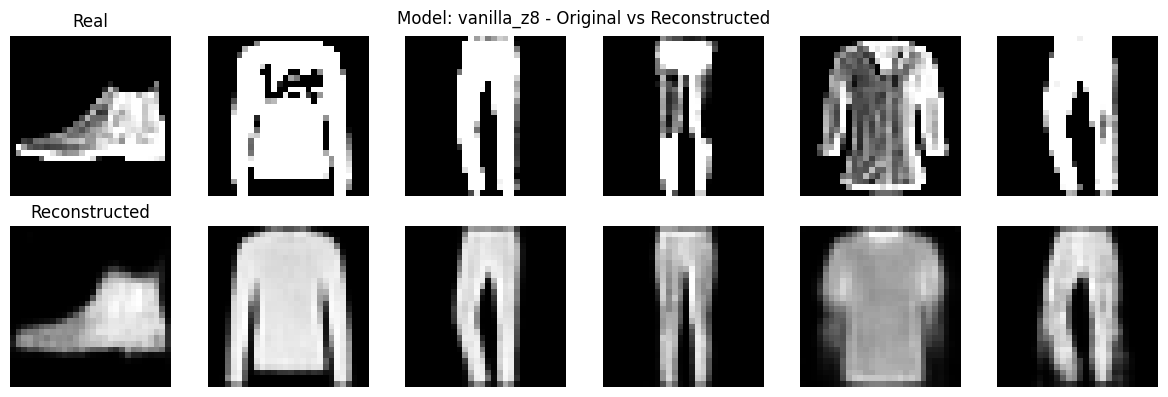

Figure saved → reconstructed_images/vanilla_z32_samples.png


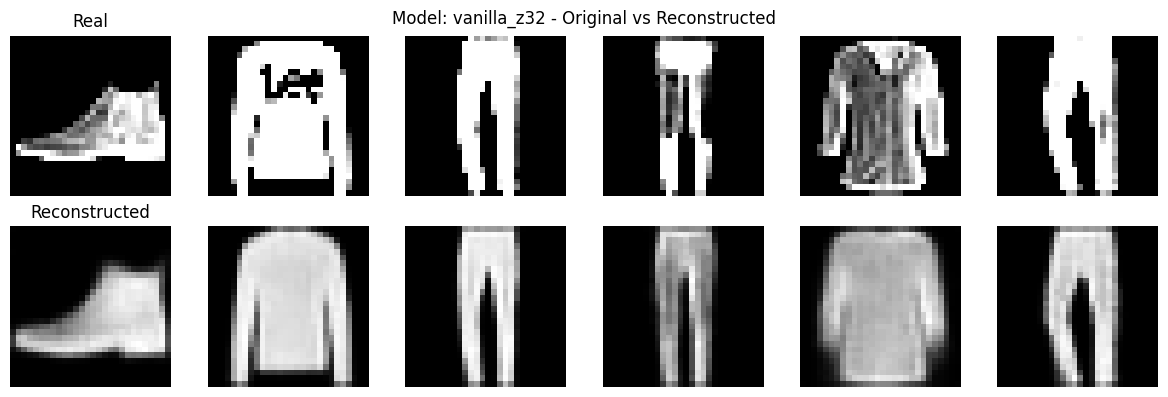

Figure saved → reconstructed_images/beta0.25_z32_samples.png


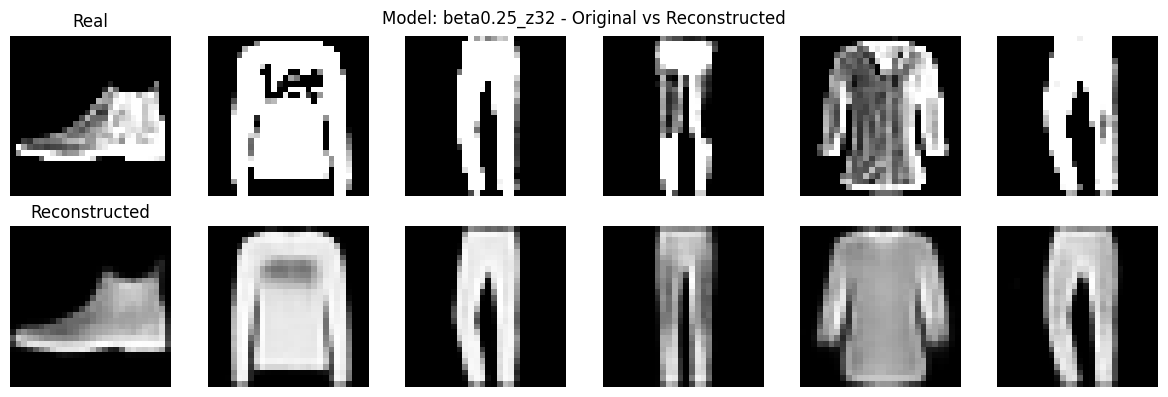

Figure saved → reconstructed_images/beta2_z32_samples.png


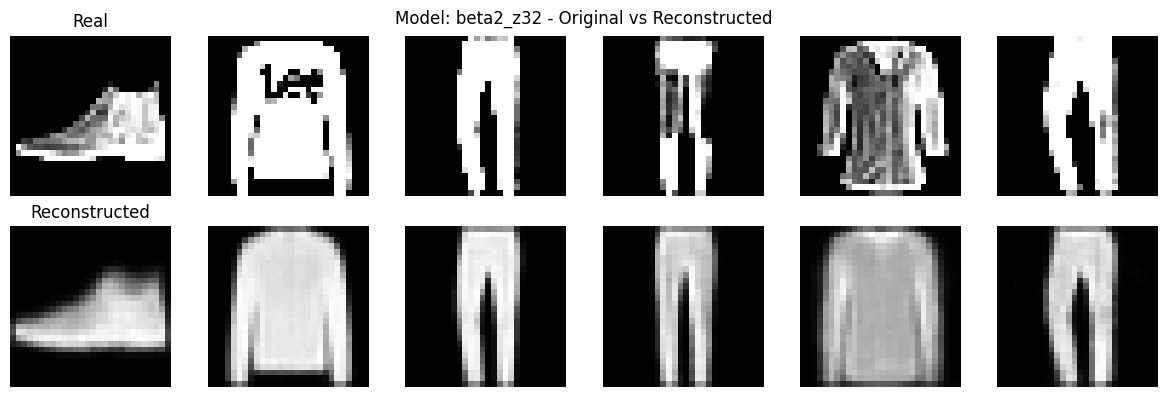

Figure saved → reconstructed_images/beta4_z32_samples.png


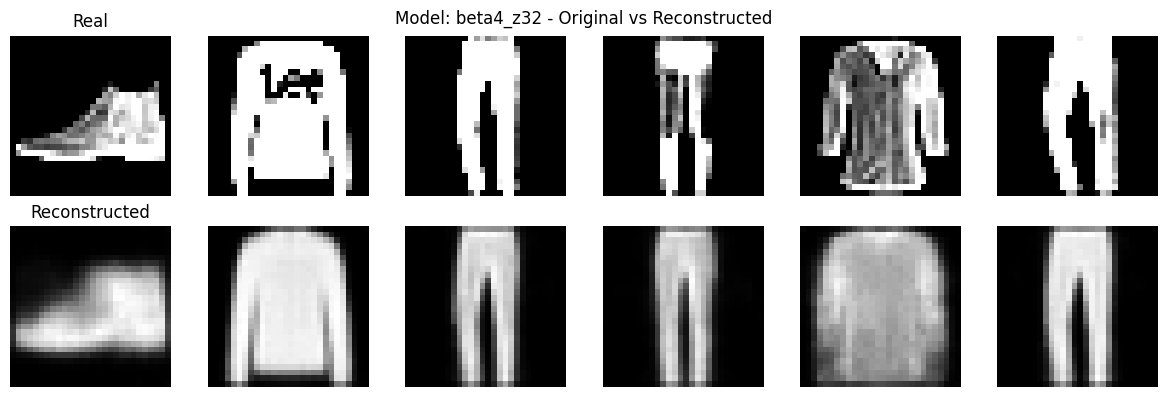

Figure saved → reconstructed_images/flow4_z32_samples.png


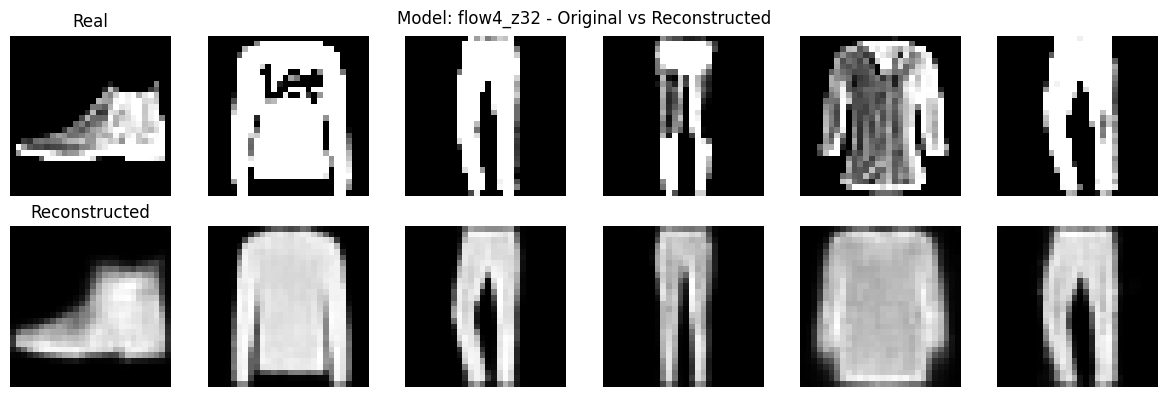

Figure saved → reconstructed_images/flow8_z32_samples.png


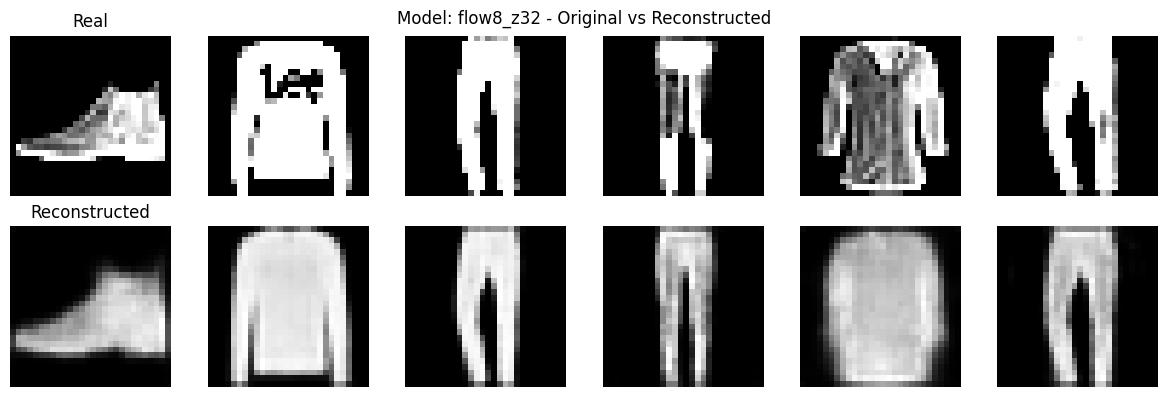

Figure saved → reconstructed_images/vanilla_z64_samples.png


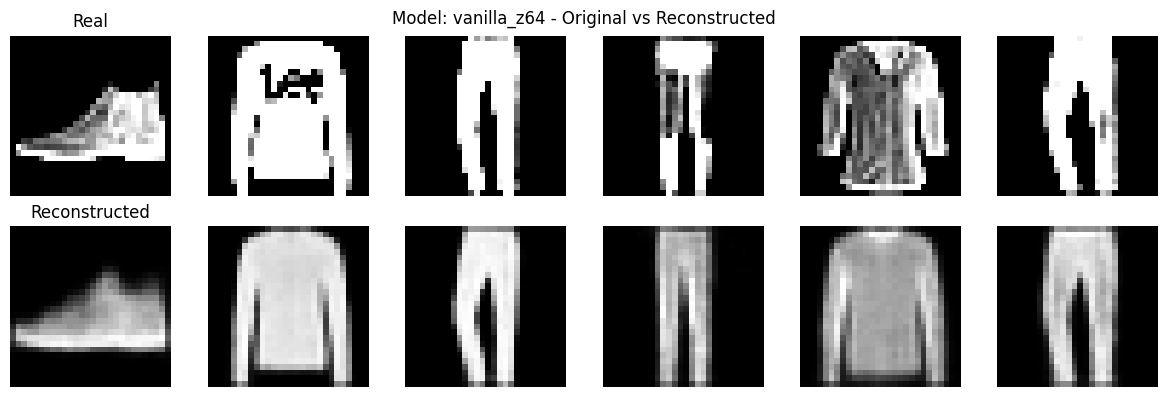

Figure saved → reconstructed_images/beta0.25_z64_samples.png


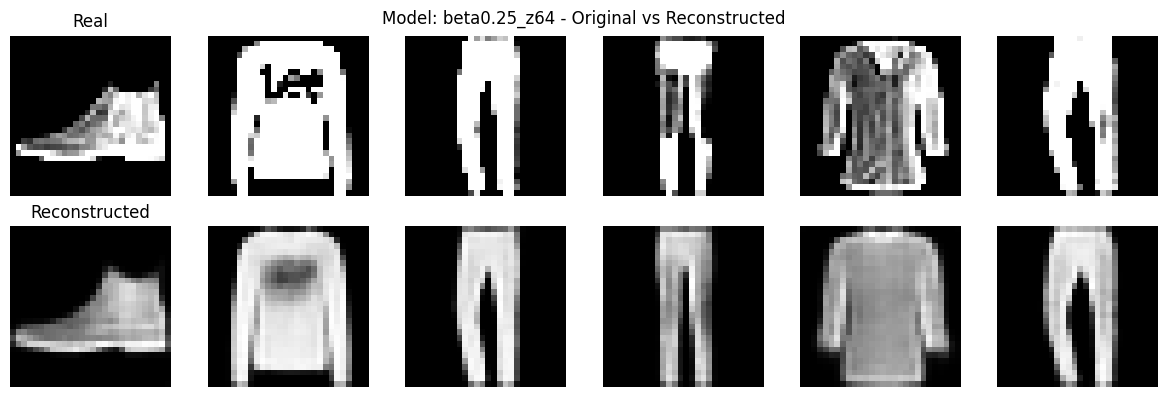

Figure saved → reconstructed_images/beta2_z64_samples.png


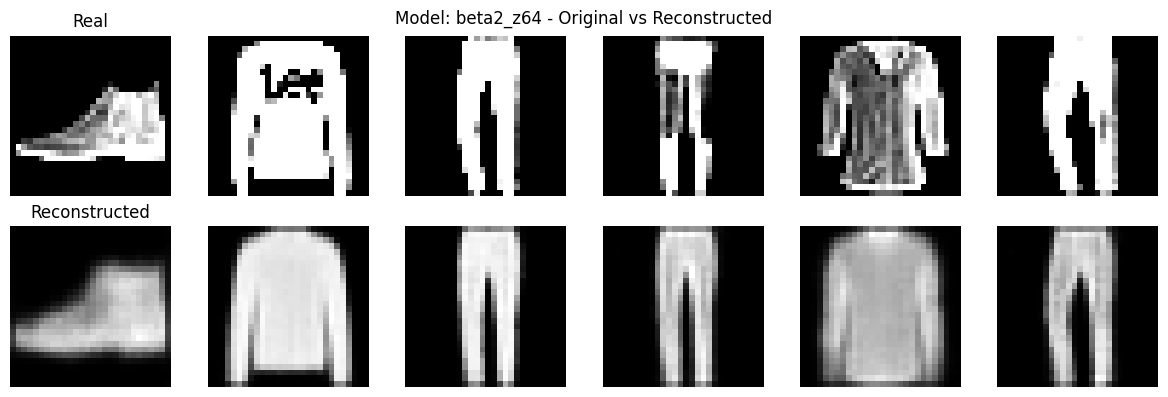

Figure saved → reconstructed_images/beta4_z64_samples.png


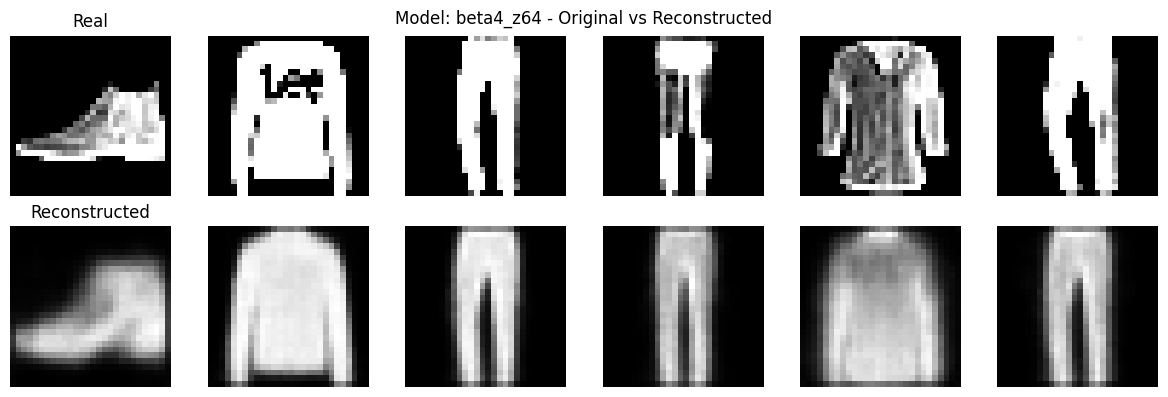

Figure saved → reconstructed_images/flow4_z64_samples.png


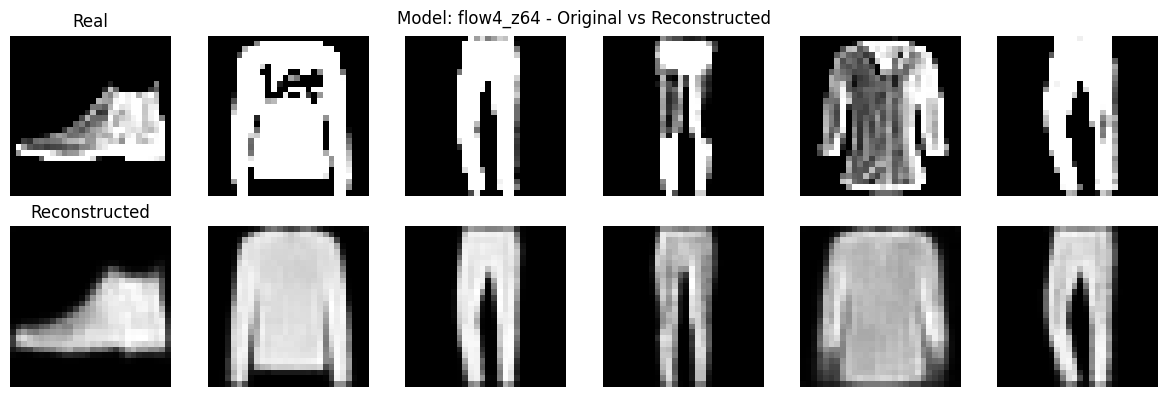

Figure saved → reconstructed_images/flow8_z64_samples.png


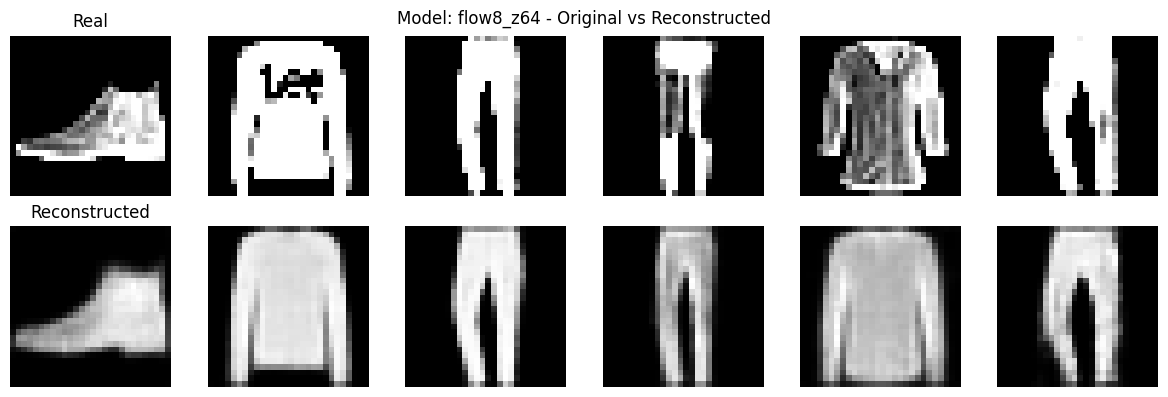

Figure saved → reconstructed_images/vanilla_z128_samples.png


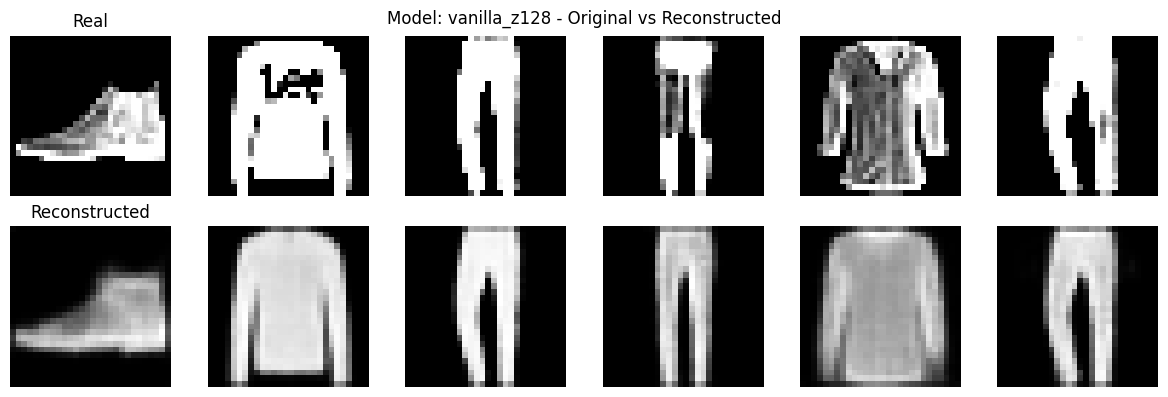

In [17]:
# --------------------------------------------------------------
# Visual comparison for reconstructed Fashion-MNIST images
# --------------------------------------------------------------

REC_DIR = Path("reconstructed_images")
REC_DIR.mkdir(parents=True, exist_ok=True)

def show_real_vs_reconstructed(
        model,
        name,
        eval_loader,
        n: int = 5,
        *,
        device: torch.device = device,
        seed: int | None = None,
        save_path: str | None = None,
):
    """
    Display a 2 × n grid: real (top) vs. reconstructed (bottom) Fashion-MNIST images.

    Assumptions
    -----------
    • Data loader yields raw 0–1 grayscale tensors  [B, 1, 28, 28].
    • Decoder produces *logits* (BCEWithLogitsLoss was used), so we apply sigmoid.
      If your decoder already ends with Sigmoid(), the extra sigmoid is a no-op.
    """
    model.eval()

    # -------- get a batch of real images --------
    real_batch, _ = next(iter(eval_loader))
    real = real_batch[:n].to(device, non_blocking=True)      # [n,1,28,28]

    # -------- forward pass to obtain reconstructions --------
    with torch.no_grad():
        x_hat, *_ = model(real)

    recon = x_hat.clamp_(0, 1).cpu()  # clamp & CPU - clamp reconstructions to [0,1] and move to CPU
    real  = real.cpu().clamp_(0, 1)   # CPU & clamp - move original images to CPU and clamp to [0,1]

    # -------- plotting --------
    fig, axes = plt.subplots(2, n, figsize=(2 * n, 4))
    for i in range(n):
        axes[0, i].imshow(real[i, 0], cmap='gray')
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Real")

        axes[1, i].imshow(recon[i, 0], cmap='gray')
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Figure saved → {save_path}")

    plt.suptitle(f"Model: {name} - Original vs Reconstructed")
    plt.show()


for name, mdl in models.items():
    out_file = REC_DIR / f"{name}_samples.png"
    show_real_vs_reconstructed(mdl, name, test_loader, n=6, device=device, seed=42, save_path=out_file)



Grid saved → generated_images/all_models_grid.png


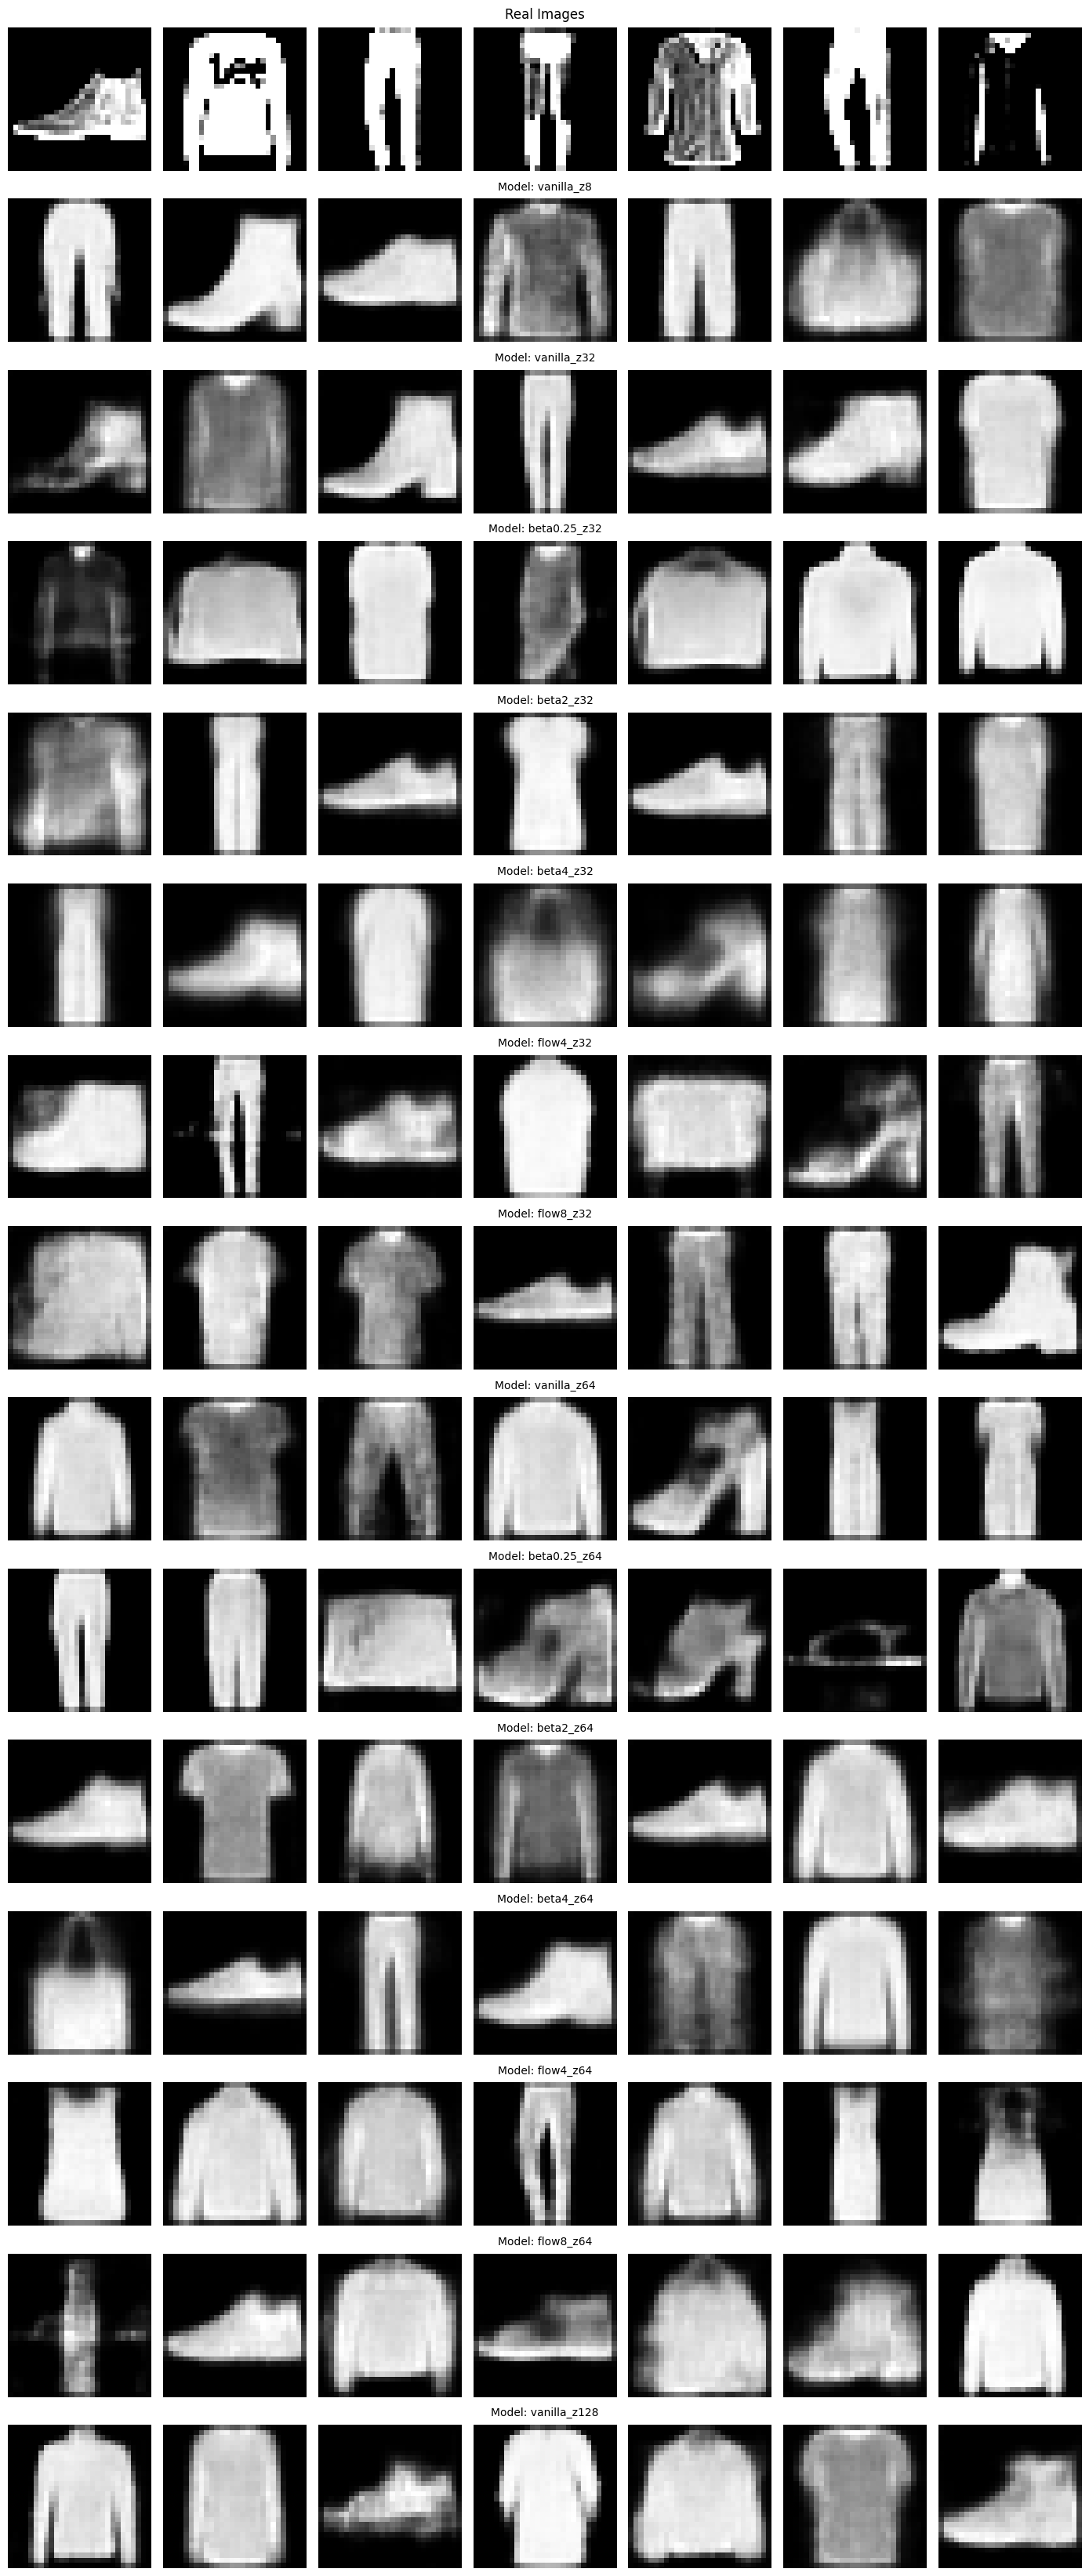

In [18]:
# --------------------------------------------------------------
# Visual presentation of generated Fashion-MNIST images
# --------------------------------------------------------------

GEN_DIR = Path("generated_images")
GEN_DIR.mkdir(exist_ok=True)

def grid_real_and_generated(models: dict[str, nn.Module],
                            eval_loader,
                            n: int = 6,
                            *,
                            device=device,
                            seed: int | None = 42,
                            save_name: str | None = "all_models_grid.png"):
    """
    Build a single image grid containing:
        • 1st row : `n` real Fashion‑MNIST samples
        • next k rows : samples generated by each of the `k` models

    Parameters
    ----------
    models : dict[str, nn.Module]
        Mapping name → model instance.
    eval_loader : DataLoader
        Loader that yields *unnormalised* [0,1] grayscale tensors.
    n : int
        Number of columns (images) per row.
    device : torch.device
        Device on which to run the decoders.
    seed : int | None
        RNG seed for reproducible latent vectors; `None` = random every call.
    save_name : str | None
        If given, the grid is saved under `generated_images/<save_name>`.
    """
    # ---------- fix RNG for reproducibility ----------
    if seed is not None:
        torch.manual_seed(seed)

    # ---------- grab one batch of real images ----------
    real_batch, _ = next(iter(eval_loader))
    real = real_batch[:n].to(device, non_blocking=True).clamp_(0, 1)

    # ---------- prepare the matplotlib canvas ----------
    n_rows = 1 + len(models)
    fig, axes = plt.subplots(n_rows, n, figsize=(2 * n, 2.2 * n_rows))
    axes = axes.reshape(n_rows, n)  # in case n==1

    # ---- row 0 : real images ----
    for i in range(n):
        axes[0, i].imshow(real[i, 0].cpu(), cmap="gray")
        axes[0, i].axis("off")
    axes[0, n//2].set_title("Real Images", pad=8, fontsize=12)
    # ---------- generated rows ----------
    for r, (name, model) in enumerate(models.items(), start=1):
        model.eval()
        model.to(device)

        # latent dim inference
        latent_dim = getattr(model, "latent_dim",
                             model.fc_mu.out_features if hasattr(model, "fc_mu") else None)

        # one shared latent batch per model
        z = torch.randn(n, latent_dim, device=device)
        with torch.no_grad():
            gen = model.decode(z).clamp_(0, 1).cpu()      # [n,1,28,28]

        for i in range(n):
            axes[r, i].imshow(gen[i, 0], cmap="gray")
            axes[r, i].axis("off")


        # Model name
        axes[r, n//2].set_title(f"Model: {name}", pad=8, fontsize=10)


    plt.tight_layout()
    if save_name:
        out_path = GEN_DIR / save_name
        fig.savefig(out_path, dpi=150, bbox_inches="tight")
        print(f"Grid saved → {out_path}")
    plt.show()


# ---------------- run & save ----------------
grid_real_and_generated(models, test_loader, n=7,
                        device=device, seed=42,
                        save_name="all_models_grid.png")
